In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sp
from skimage import color

%matplotlib inline

# Question 1: Seam Carving

In [5]:
# 1) a


def gradMagnitude(I):
    '''
    Calculates and returns the gradient magnitudes and partial derivatives of the given RGB image, I
    
    I: RGB image, a 3D array of dimension LxWx3
    
    return: Three 2D matrices containing the magniture of the gradient, and the partial derivatives in x and y respectively
    '''
    I = color.rgb2gray(I)# convert to grayscale (professor said we are allowed)
    
    partialX = np.array([1, -1])  # filter to compute partial derivative in x (using convolution)
    partialY = np.array([1, -1])  # filter to compute partial derivative in x (using convolution)

    # initialize matrices of horizontal and vertical derivatives
    dX = np.zeros(np.shape(I))
    dY = np.zeros(np.shape(I))

    # apply horizontal derivative to each row
    for i in range(np.shape(I)[0]):
        dX[i] = sp.signal.convolve(I[i],partialX, mode='same')

    # apply vertical derivative to each column
    for i in range(np.shape(I)[1]):
        dY[:,i] = sp.signal.convolve(I[:,i],partialY, mode='same') 
    
    gm = np.sqrt(dX**2 + dY**2)
    
    return gm, dX, dY  # gm is the gradient magnitudes


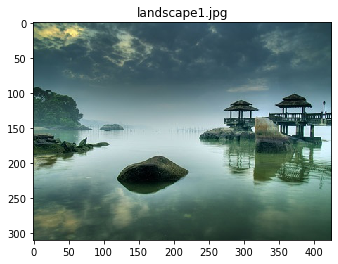

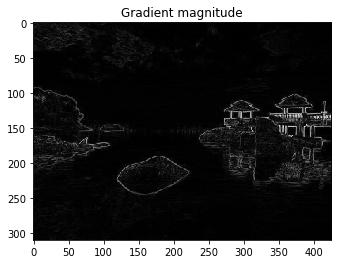

In [6]:
# Testing 1 a)

# read in the image
landscape = plt.imread('landscape1.jpg')[:,:,:3]  # remove the transparency channel
plt.imshow(landscape)
plt.title("landscape1.jpg")
plt.show()

# test the function
gm, _, _ = gradMagnitude(landscape)

plt.imshow(gm, cmap='gray')
plt.title("Gradient magnitude")
plt.show()

In [7]:
# 1 b) and c)

def removeColumn(image, gm):
    '''
    Given an RGB (three channel) image and its gradient magnitudes (gm), finds the (vertical) connected path of pixels 
    that has the smallest sum of gradients, and removes the pixels in the path from the image, giving a new image with one
    column less than the original.
    '''

    # 1 b)
    # finding the connected path with smallest sum of gradient magnitudes at each location in the image
    
    pathGradSums = np.zeros(np.shape(gm))
    parents = np.zeros(np.shape(gm))  # stores which pixel is the previous pixel in the connected path
                                        # '-1', '0', or '1' corresponding to above+left, directly above, or above+right
                                        # -1 means go down a row and down a column, +1 means go down a row but up a column
                                        # 2 means nothing above (used as placeholder for first row)

    # Dynamic Programming: calculate values of gradient sums of connected paths ending at each pixel
    for row in range(np.shape(pathGradSums)[0]):
        for col in range(np.shape(pathGradSums)[1]):
            if row == 0:
                pathGradSums[row, col] = gm[row, col]
                parents[row, col] = 2

            else:
                # gradient sums of connected paths ending above current pixel (up to three "parent" pixels):
                parentSums = np.array([np.inf, np.inf, np.inf])

                # connected path ending directly above the pixel at [row, col] (ie. the current pixel)
                parentSums[1] = pathGradSums[row-1, col]

                # connected path ending above and to the left of the pixel at [row, col]
                if col > 0:
                    parentSums[0] = pathGradSums[row-1, col-1]

                # connected path ending above and to the right of the pixel at [row, col]
                if col < np.shape(pathGradSums)[1] - 1:
                    parentSums[2] = pathGradSums[row-1, col+1]



                # add gradient magnitude at [row, col] to smallest gradient sum of the paths ending at the pixel(s) above
                pathGradSums[row, col] = gm[row, col] + np.min(parentSums)
                parents[row, col] = np.argmin(parentSums) - 1



    # Strategy going forward:
        # 1) find pixel in the last row at which the connected path with the lowest gradient magnitude sum ends
        # 2) starting from that pixel, use the "parents" matrix to follow the connected path upwards until
        #    you reach the top row, saving the (raveled) index of each pixel in the path into a list

        # after step 2, part 1 b) is done (we  have found the connected path)

        # 3) make a copy of the image and unravel it into a 1D array (need a copy of each of the three channels)
        # 4) delete the values corresponding to the indices, then reshape back into a 2D array
        #    of dimensions equal to the original image, but with one less column
        
        # After step 4, 1 c) is done

    # step 1
    finalPixelColumn = np.argmin(pathGradSums[-1, :])

    # step 2
    row = np.shape(pathGradSums)[0] - 1  # start at last row
    col = finalPixelColumn
    rowLength = np.shape(pathGradSums)[1]

    # index is (row, finalPixelColumn), so ravleled index is rowLength*row + col)
    removeIndices = [rowLength*row + col]

    while row > 0:
        parentColumn = col + int(parents[row, col])
        removeIndices.append(rowLength*(row-1) + parentColumn) 

        col = parentColumn
        row -= 1

    
    # 1 c) (removing the pixels in the path from the image)
    
    # step 3
    shape = (np.shape(pathGradSums)[0], np.shape(pathGradSums)[1]-1)
    
    raveledImage = np.array([np.copy(image[:, :, 0]).ravel(), np.copy(image[:, :, 1]).ravel(),
                              np.copy(image[:, :, 2]).ravel()])
    
    # step 4
    
    modifiedImage = []
    
    for channel in range(3):       
        modifiedChannel = np.delete(raveledImage[channel], removeIndices)       
        modifiedChannel = modifiedChannel.reshape(shape)
        modifiedImage.append(modifiedChannel)
    
    # convert to np array and rearrange the dimensions so the third dimension corresponds to channel
    modifiedImage = np.moveaxis(np.array(modifiedImage), 0, 2)
    
    
    return modifiedImage


(310, 425, 3)


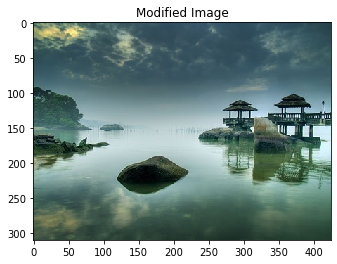

(310, 424, 3)


In [8]:
# testing 1 b) and c)
print(np.shape(landscape))
im = removeColumn(landscape, gm)
plt.imshow(im)
plt.title("Modified Image")
plt.show()
print(np.shape(im))


In [9]:
# 1 d)
def seamCarving(image, numCols):
    '''
    Given an RGB image, uses seam carving to remove columns (the amount of columns removed is given by numCols)
    '''
    im = image
    for i in range(numCols):
        gm, _, _ = gradMagnitude(im)
        im = removeColumn(im, gm)


    return im


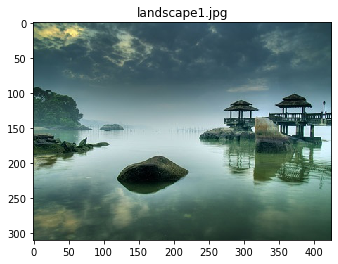

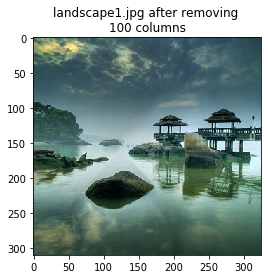

In [10]:
# testing 1 d) on another image

# read in the image
landscape = plt.imread('landscape1.jpg')[:,:,:3]  # remove any extra channels
plt.imshow(landscape)
plt.title("landscape1.jpg")
plt.show()

# remove 100 columns
im = seamCarving(landscape, 100)
plt.imshow(im)
plt.title("landscape1.jpg after removing \n100 columns")
plt.show()

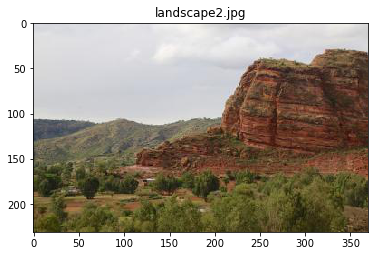

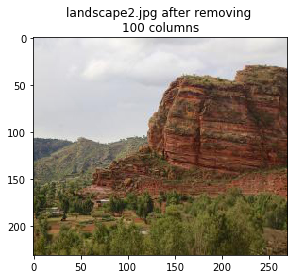

In [12]:
# testing 1 d)

# read in the image
landscape2 = plt.imread('landscape2.jpg')[:,:,:3]  # remove any extra channels
plt.imshow(landscape2)
plt.title("landscape2.jpg")
plt.show()

# remove 100 columns
im2 = seamCarving(landscape2, 100)
plt.imshow(im2)
plt.title("landscape2.jpg after removing \n100 columns")
plt.show()

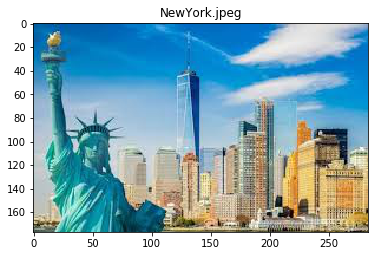

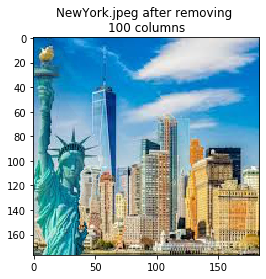

In [102]:
# testing 1 d) on another image

# read in the image
NY = plt.imread('NewYork.jpeg')[:,:,:3]  # remove any extra channels
plt.imshow(NY)
plt.title("NewYork.jpeg")
plt.show()

# remove 100 columns
im3 = seamCarving(NY, 100)
plt.imshow(im3)
plt.title("NewYork.jpeg after removing \n100 columns")
plt.show()

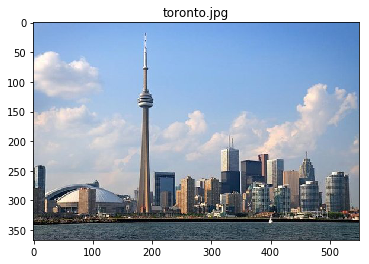

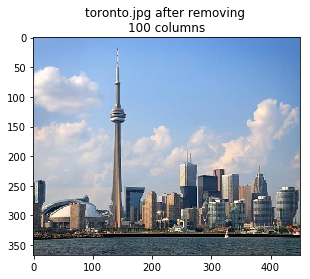

In [5]:
# testing 1 d) on another image

# read in the image
TO = plt.imread('toronto.jpg')[:,:,:3]  # remove any extra channels
plt.imshow(TO)
plt.title("toronto.jpg")
plt.show()

# remove 100 columns
im4 = seamCarving(TO, 100)
plt.imshow(im4)
plt.title("toronto.jpg after removing \n100 columns")
plt.show()

# Question 2: Harris Corner Detector

In [14]:
def Gaussian(x, sigma):
    B = (2.0*sigma**2.0)
    
    return np.exp(  ( ((-1.0)/B)  *   (x**2.0)   )   )
def gaussianFilter(sigma):
    '''
    Returns an isotropic gaussian filter with given standard deviation (sigma). The size of the filter is about floor(3*sigma),
    since in lecture it was said that 3-5*sigma is usually a good choice for the size of the filter
    
    Note: the filter returned is modified to always be odd in dimension, so that the center pixel is the peak of the gaussian
          (this is whay the size is "about floor(5*sigma)")
    '''
    size = np.floor(3*sigma)
    
    # make sure size is odd:
    if size%2 == 0:
        size += 1
    
    # create meshgrid
    
    x = np.arange(-1*size, size+1)


    # apply gaussian pdf to meshgrid
    g = Gaussian(x, sigma)
    
    # normalize
    return g/np.sum(g)

In [17]:
def Harris(I, thresh=0.01, alpha=0.05, sigma=1, radius=1):
    '''
    Implementation of Harris corner detector. Given image I, returns an array of the corners in the image.
    
    thresh: the threshold for determining which R values constitute corners
    alpha: the coefficient of trace(M)^2 in the calculation of R. The value of alpha defaults to 0.05, since
           the lecture slides suggest 0.04 to 0.06
    sigma: the std dev to use for the gaussian filter
    radius: the radius used in non-maxima supression
    
    The parameters above default to values that worked well in testing
    
    Note: images should be smoothed before being passed to this function for best results
    '''
    
    # Converting image to greyscale:
    I = color.rgb2gray(I)
    
    # Computing derivatives:
    _, Ix, Iy = gradMagnitude(I)
    
    Ix2 = Ix*Ix
    Iy2 = Iy*Iy
    IxIy = Ix*Iy

    
    # create gaussian filter:
    g = gaussianFilter(sigma)
    
    
    # apply filter to gradients:
    grads = [Ix2, Iy2, IxIy]
    MVals = [np.zeros(np.shape(I)), np.zeros(np.shape(I)), np.zeros(np.shape(I))]
    
    for i in range(3):
        for row in range(np.shape(I)[0]):
            MVals[i][row, :] = signal.convolve(grads[i][row, :], g, mode='same')

        for col in range(np.shape(I)[1]):
            MVals[i][:, col] = signal.convolve(MVals[i][:, col], g, mode='same')

    
    
    '''
    At each point in the image, we have some M
    
    M = [[MVals[0], MVals[2]],
        [MVals[2], MVals[1]]]
    
    Therefore, we have:
    
    det(M) = MVals[0]*MVals[1] - MVals[2]**2
    
    trace(M) = (MVals[0] + MVals[1])
    '''
    
    # calculate "cornerness":
    detM = MVals[0]*MVals[1] - MVals[2]**2
    traceM = (MVals[0] + MVals[1])**2 
    
    R = detM - alpha*traceM**2
    
    
    # remove values below threshold:
    R = np.where(R > thresh*np.max(R), R, 0)
    
    
    # non-maxima supression:
    supressedR = np.zeros(np.shape(R))

    for row in range(radius, np.shape(R)[0]-radius):  # ignore edges of image for simplicity
        for col in range(radius, np.shape(R)[1]-radius):
            if not R[row, col] == 0:
                # maxium value within radius of (row, col):
                nearbyPixels = R[(row-radius):(row+radius), (col-radius):(col+radius)]
                
                if R[row, col] >= np.max(nearbyPixels):
                    supressedR[row, col] = 255
    
    # locations of corners:
    cornerLocs = np.argwhere(R>0)
    
    return cornerLocs



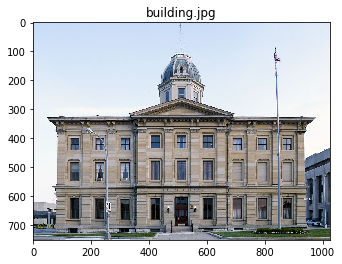

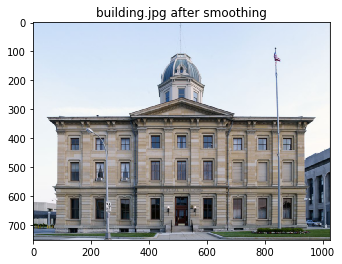

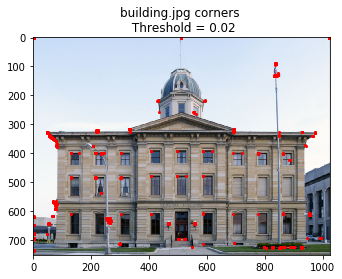

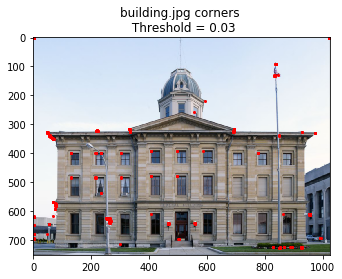

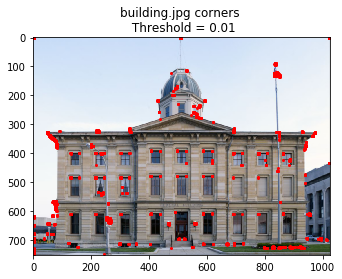

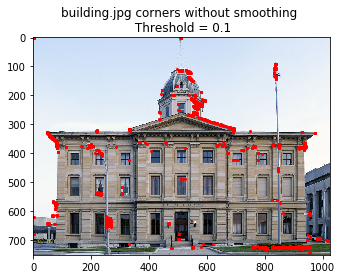

In [21]:
# testing question 3

# read in the image
building = plt.imread('building.jpg')[:,:,:3]  # remove any extra channels


# create gaussian filter:
g = gaussianFilter(1)


# blurring the image (since corner detection is sensitive to noise):
blurredBuilding = np.zeros(np.shape(building))

for i in range(3):
    for row in range(np.shape(building)[0]):
        blurredBuilding[row, :, i] = signal.convolve(building[row, :, i], g, mode='same')

    for col in range(np.shape(building)[1]):
        blurredBuilding[:, col, i] = signal.convolve(blurredBuilding[:, col, i], g, mode='same')

# Normalize:        
blurredBuilding = blurredBuilding/np.max(blurredBuilding)

plt.imshow(building)
plt.title("building.jpg")
plt.show()

plt.imshow(blurredBuilding)
plt.title("building.jpg after smoothing")
plt.show()

# get corners
cornerLocs = Harris(blurredBuilding, thresh=0.02)


# plotting:
plt.imshow(blurredBuilding)
plt.title("building.jpg corners \n Threshold = 0.02")
plt.plot(cornerLocs[:, 1], cornerLocs[:, 0],'ro', markersize=2)
plt.show()



cornerLocs = Harris(blurredBuilding, thresh=0.03)
plt.imshow(blurredBuilding)
plt.title("building.jpg corners \n Threshold = 0.03")
plt.plot(cornerLocs[:, 1], cornerLocs[:, 0],'ro', markersize=2)
plt.show()


cornerLocs = Harris(blurredBuilding, thresh=0.01)
plt.imshow(blurredBuilding)
plt.title("building.jpg corners \n Threshold = 0.01")
plt.plot(cornerLocs[:, 1], cornerLocs[:, 0],'ro', markersize=2)
plt.show()


cornerLocs = Harris(building, thresh=0.1)
plt.imshow(building)
plt.title("building.jpg corners without smoothing \n Threshold = 0.1")
plt.plot(cornerLocs[:, 1], cornerLocs[:, 0],'ro', markersize=2)
plt.show()
